# Repeated Bertrand, test notebook

In [ ]:
# %cd game_tournament

In [2]:
from scipy.optimize import minimize, fsolve

In [3]:
from game_tournament.game import RepeatedBertrandGame, Tournament
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 

## Cournot demand

In [4]:
def demand_function(p1, p2, i): 
    u1 = np.exp(1.-1.0*p1)
    u2 = np.exp(1.-1.0*p2)
    u0 = 1.0 
    
    denom = u0 + u1 + u2
    
    if i == 0: 
        return u1/denom 
    elif i == 1: 
        return u2/denom
    else: 
        raise Exception(f'Cannot return demand for player i={i}: must be 0 or 1.')

In [5]:
demand_function(4., 4., 1)

0.045278500743629074

## Working analytically 

Just to get a feel for the demand function, let's write some code that performs best responses. To do this, we want to solve $BR_i(p_j) \equiv \arg \max_{p_i} \pi_i (p_i, p_j)$. We do this using `scipy.optimize.minimize`, so since it minimizes (rather than maximizes), we remember to multiply by `-1`.  

In [6]:
c = 0.5
pmin = c
pmax = 10.
def BR(pj, i): 
    if i == 0: 
        f = lambda p : -1.0 * demand_function(p, pj, i) * (p-c)
    elif i == 1: 
        f = lambda p : -1.0 * demand_function(pj, p, i) * (p-c)
    else: 
        raise Exception('i must be 0 or 1 ')

    res = minimize(f, pj, bounds=[(pmin, pmax)])
    pi = res.x[0]
    
    return pi 


We can relatively quickly  evaluate the $BR$ functions over the range, `[pmin; pmax]` and plot the funcitons together. 

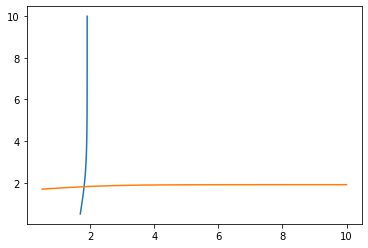

In [7]:
pp = np.linspace(pmin, pmax, 100)
pp1 = np.empty((100,))
pp2 = np.empty((100,))
for i,p in enumerate(pp): 
    pp1[i] = BR(p, 0)
    pp2[i] = BR(p, 1)
    
plt.plot(pp1, pp, label='Player 1');
plt.plot(pp, pp2, label='Player 2');

If we wanted to, we can try to solve for the system of best response equations that define the pure strategy Nash-equilibrium of the game. 

In [8]:
def eq_fun(p): 
    P = np.empty((2,))
    for i in range(2): 
        j = 1-i
        P[i] = BR(p[j], i)
    return P - p 

In [9]:
p_nash = fsolve(eq_fun, np.array([5., 5.]))
print(f'The pure strategy NE of the game is: {p_nash}')

The pure strategy NE of the game is: [1.80826765 1.80826765]


# Interact with the game directly

In [10]:
# some examples to work with 
from examples.players_cont.player2 import player as player1
from examples.players_cont.player3 import player as player2

In [11]:
# initialize instances of two player functions
p1 = player1()
p2 = player2()

# choose who is player 1 and 2 
p1.i = 0
p2.i = 1

# define the game 
price_range = (0.0, 5.0)
marginal_cost = 1.0
beta = 0.99
G = RepeatedBertrandGame(p1, p2, demand_function, marginal_cost, price_range, beta)

Play a single round of the game and print what happened 

In [12]:
G.play_round()

In [13]:
print(G.history)

[array([5.   , 4.995])]


Play a lot of rounds and plot the resulting series of prices. 

In [14]:
for it in range(100): 
    G.play_round()

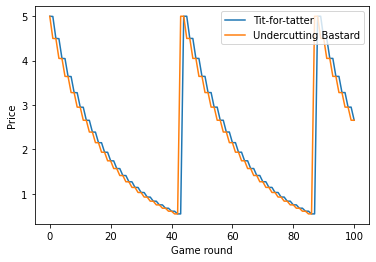

In [15]:
plt.plot(G.history); 
plt.legend([player.name for player in G.players]); 
plt.xlabel('Game round'); plt.ylabel('Price'); 

In [16]:
payoffs = G.compute_total_payoff_from_history(beta=beta)
for i,player in enumerate(G.players): 
    print(f'{player.name: <25}: {payoffs[i]: 8.2f}')

Tit-for-tatter           :     5.90
Undercutting Bastard     :     6.26


# Run a tournament 
This will 

1. read all *.py files in `player_file_path` and load a `player` class from each 
2. set up an all_play_all tournament between said players 
3. provide rankings (win = 2, draw = 1, loss = 0 points)

In [17]:
players_file_path = './examples/players_cont/'
tournament = Tournament(players_filepath=players_file_path, game=RepeatedBertrandGame, tournament_name='PriceComp')
print(tournament)

Tournament ready with 5 players


In [18]:
beta = 0.99 
tournament.start_tournament(T=100, beta=beta, demand_function=demand_function, marginal_cost=1.0, price_range=price_range, discount_factor=beta)

100%|██████████| 10/10 [00:00<00:00, 143.88it/s]


Top placements are:
                   Name  Points
3  Undercutting Bastard     8.0
1               Randawg     6.0
4        Tit-for-tatter     3.0
2                  PMAX     3.0
0                  pmin     0.0
